In [1]:
import os 
from PIL import Image
import numpy as np
from pathlib import Path #windows issues, need to change \ to /
import multipagetiff as mtif
from matplotlib import pyplot as plt
import skimage.io as skio
from skimage.metrics import structural_similarity as ssim
import cv2

In [ ]:
#pip install imutils - for rotating images

In [2]:
! git clone https://github.com/peng-lab/PyBaSiC.git

fatal: destination path 'PyBaSiC' already exists and is not an empty directory.


In [2]:
# FUNCTIONS
# computation of sum of squared errors, which is working, but we still need to normalise it

def mse(imageA, imageB):
# the 'Mean Squared Error' between the two images is the
# sum of the squared difference between the two images;
# NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])

# return the MSE, the lower the error, the more "similar"
# the two images are
    return err
# function for mean squared error and structural similarity for two pictures

def compare_images(imageA, imageB, title = 'Comparison'):
# compute the mean squared error and structural similarity
# index for the images
    m = mse(imageA, imageB)
    s = ssim(imageA, imageB)
# setup the figure
    fig = plt.figure(title)
    plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))
# show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(imageA, cmap = plt.cm.gray)
    plt.axis("off")
# show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(imageB, cmap = plt.cm.gray)
    plt.axis("off")
# show the images
    plt.show()
    
#FUNCTION FOR DOWNSAMPLING INTO DESIRABLE SHAPE

import math
import scipy
def prray(inArray, finalShape, sameSum=False, **zoomKwargs):
    inArray = np.asarray(inArray, dtype = np.double)
    inShape = inArray.shape
    assert len(inShape) == len(finalShape)
    mults = []
    for i in range(len(inShape)):
        if finalShape[i] < inShape[i]:
            mults.append(int(np.ceil(inShape[i]/finalShape[i])))
        else:
            mults.append(1)
    tempShape = tuple([i * j for i,j in zip(finalShape, mults)])

    zoomMultipliers = np.array(tempShape) / np.array(inShape) + 0.0000001
    rescaled = scipy.ndimage.zoom(inArray, zoomMultipliers, **zoomKwargs)

    for ind, mult in enumerate(mults):
        if mult != 1:
            sh = list(rescaled.shape)
            assert sh[ind] % mult == 0
            newshape = sh[:ind] + [sh[ind] / mult, mult] + sh[ind+1:]
            rescaled.shape = list(map(int, newshape))
            rescaled = np.mean(rescaled, axis = ind+1)
    assert rescaled.shape == finalShape

    if sameSum:
        extraSize = np.prod(finalShape) / np.prod(inShape)
        rescaled /= extraSize
    return rescaled

#REFLECTING

def reflect_x_axis(image):
    plt.axis('off')
    rows, cols = image.shape
    M = np.float32([[1,  0, 0   ],
                    [0, -1, rows],
                    [ 0, 0, 1   ]])
    image_reflected = cv2.warpPerspective(image,M,(int(cols),int(rows)))
    plt.axis('off')
    plt.imshow(image_reflected)
    return image_reflected
def reflect_y_axis(image):
    plt.axis('off')
    rows, cols = image.shape
    M = np.float32([[-1,  0, cols   ],
                    [0, 1, 0],
                    [ 0, 0, 1   ]])
    image_reflected = cv2.warpPerspective(image,M,(int(cols),int(rows)))
    plt.axis('off')
    plt.imshow(image_reflected)
    return image_reflected


# function to rotate circle part of the image (using mask)
def circle_rotate(image, x, y, radius, degree):
    img_arr = np.asarray(image)
    box = (x-radius, y-radius, x+radius+1, y+radius+1)
    crop = image.crop(box=box)
    crop_arr = np.asarray(crop)
    # build the cirle mask
    mask = np.zeros((2*radius+1, 2*radius+1))
    for i in range(crop_arr.shape[0]):
        for j in range(crop_arr.shape[1]):
            if (i-radius)**2 + (j-radius)**2 <= radius**2:
                mask[i,j] = 1
    # create the new circular image
    sub_img_arr = np.empty(crop_arr.shape ,dtype='uint8')
    sub_img_arr[:,:,:3] = crop_arr[:,:,:3]
    sub_img_arr[:,:,3] = mask*255
    sub_img = Image.fromarray(sub_img_arr, "RGBA").rotate(degree)
    i2 = image.copy()
    #going back to whole image
    i2.paste(sub_img, box[:2], sub_img.convert('RGBA'))
    return i2

In [3]:
%store -r minisc_im_nocut
%store -r fg

In [ ]:
# 1) assign not fixed number of z-stacks from 2P to 127 planes from miniscope (merge more miniscope planes? or maybe less for both? how to assign them to each other?)

# 2) implenent all planes and z-stacks into python and make them matrices or linearised matrices (how to make matrices image from tif format?)

# 3) apply correlation to 2P and miniscope matrices (vectors) for that the amount of planes should be the same

# 4) create a graph: correlation values across the plane number

In [ ]:
# approach to import tif files as an array

# dirname = 'D:/20220623_PollenBrain2/test_25_frames'
# final = []
# for fname in os.listdir(dirname):
#     im = Image.open(os.path.join(dirname, fname))
#     imarray = np.array(im)
#     final.append(imarray)

# final = np.asarray(final) #array of tiff files


In [ ]:
pip install multipagetiff

In [ ]:
# Here I visualised the data that I have from 2P (I made stack in imageJ and put them here)

In [2]:
s = mtif.read_stack("test_25_frames.tif", dx=10, dz=50, units='nm') 
s

Multi-Page Stack of 27 pages. (dx=dy=10nm, dz=50nm, crop=[0, 512, 0, 512]], page limits=[0, 27])

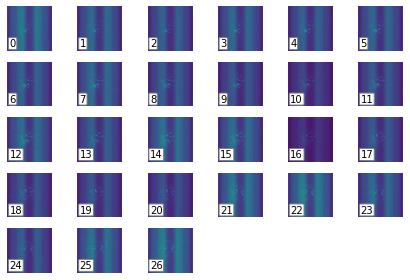

In [3]:
mtif.plot_pages(s)

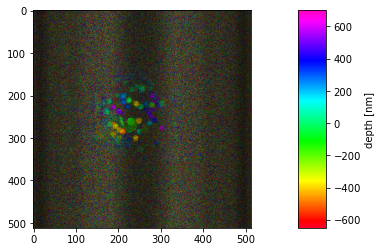

In [22]:
mtif.plot_flatten(s)

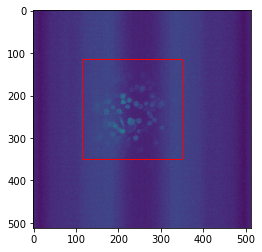

In [4]:
s.crop_horizontal = 115,350
s.crop_vertical = 115,350
mtif.plot_selection(s)

In [ ]:
mtif.plot_flatten(s)

In [ ]:
mtif.plot_flatten(s, axis=1)

In [5]:
s2 = mtif.read_stack("test_brain2.tif", dx=10, dz=50, units='nm')


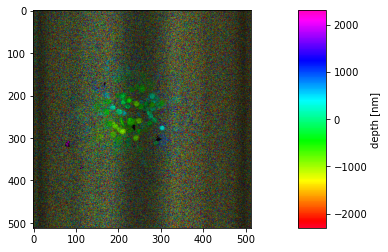

In [6]:
mtif.plot_flatten(s2)

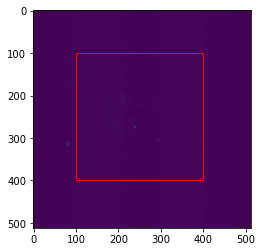

In [7]:
s2.crop_horizontal = 100,400
s2.crop_vertical = 100,400
mtif.plot_selection(s2)

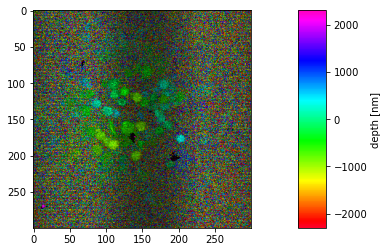

In [8]:
mtif.plot_flatten(s2)

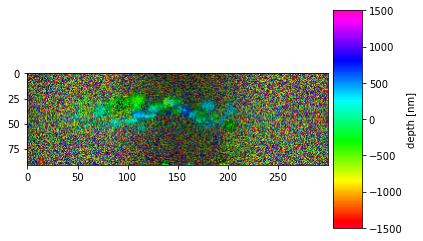

In [9]:
mtif.plot_flatten(s2, axis=1)

In [2]:
s1 = mtif.read_stack("stackbrain1.tif", dx=10, dz=50, units='nm')
s1


Multi-Page Stack of 109 pages. (dx=dy=10nm, dz=50nm, crop=[0, 512, 0, 512]], page limits=[0, 109])

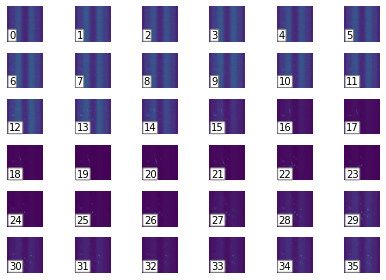

In [11]:
mtif.plot_pages(s1)

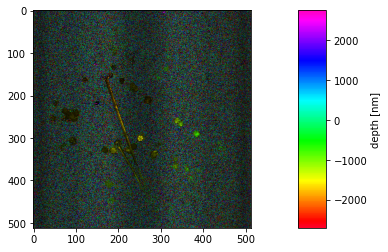

In [12]:
mtif.plot_flatten(s1)

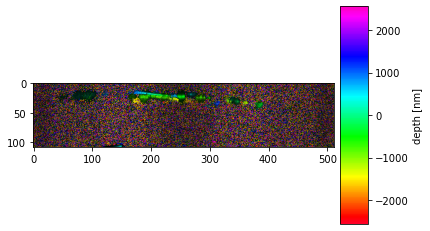

In [84]:
mtif.plot_flatten(s1, axis=1)

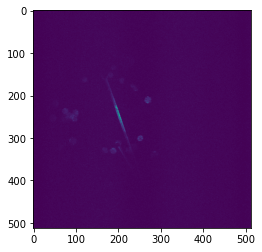

In [90]:
plt.imshow(imstack_first_brain[20,:,:])

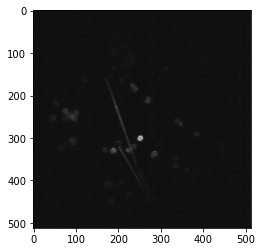

In [5]:
# importing tiff stacks as arrays
imstack1_first_brain2 = skio.imread("by_BaSC_series.tif", plugin ="tifffile") 

plt.imshow(np.mean(imstack1_first_brain2,axis = 0), cmap ="gray")
plt.show()


6.130142106922395


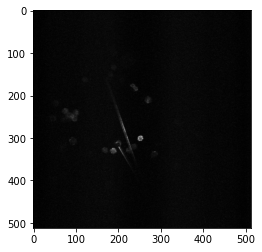

In [5]:
# importing tiff stacks as arrays
imstack1_first_brain = skio.imread("stackbrain1.tif", plugin="tifffile") 

print( imstack1_first_brain.mean() )
plt.imshow(imstack1_first_brain[22,:,:], cmap ="gray")
plt.show()
# getting rid of stripes 
imstack_first_brain = imstack1_first_brain - np.min(imstack1_first_brain,axis = 0) # new stack without minimum 

#slicing to get only necessary values
sliced_stack_b1 = imstack_first_brain[14:44,:,:]

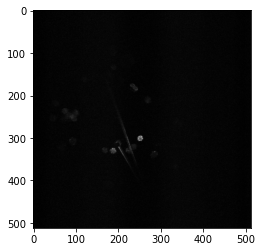

In [69]:
plt.imshow(imstack1_first_brain[23,:,:], cmap ="gray")
plt.show()

In [19]:
imstack1_first_brain.shape

(109, 512, 512)

In [17]:
sliced_stack_b1.shape

(30, 512, 512)

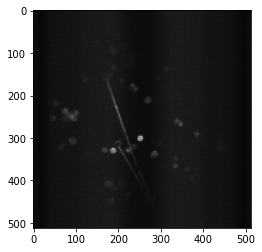

In [3]:
# to look on the whole mean of the most interesting part
plt.imshow(np.mean(sliced_stack_b1,axis = 0), cmap ="gray")
plt.show()

(512, 512)

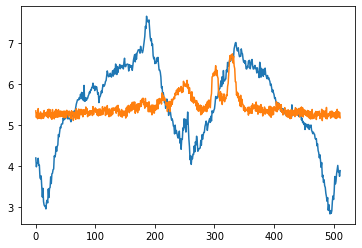

In [6]:
# using this we want to cut bad things (where connection crashed)

#plt.imshow(np.min(sliced_stack_b1,axis = 0))
meanimg = np.mean(sliced_stack_b1, axis = 0) - np.min(sliced_stack_b1,axis = 0)
#plt.imshow(meanimg)
plt.plot(np.mean(meanimg, axis = 0))
plt.plot(np.mean(meanimg, axis = 1))
meanimg.shape

In [7]:
twop_im = np.mean(sliced_stack_b1, 0)
twop_im.shape
%store twop_im #store in jupyter

Stored 'twop_im' (ndarray)


UsageError: Unknown variable '#store'


In [9]:
# cleaned with BySiC
twop_im_cl = np.mean(imstack1_first_brain2, 0)
twop_im_cl.shape
%store twop_im_cl

Stored 'twop_im_cl' (ndarray)


In [34]:
minisc_im_nocut.shape

(512, 512)

In [8]:
%store -r minisc_cut_im2
minisc_cut_im2.shape

(512, 512)

In [6]:
%store -r minisc_im_nocut
%store -r fg
%store -r twop_im_cl
%store -r twop_im_cl_cut
%store -r twop_im_clean

In [ ]:
# steps to put everything in the loop
# 1)make sure that pics are same reflected
# 2) rotation - png, comparison array (maybe try to compare png without converting to arrays)

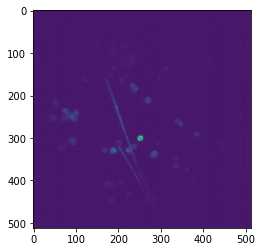

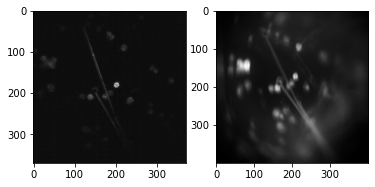

Stored 'twop_im_cl_cut' (ndarray)


In [51]:
plt.imshow(twop_im_cl)
#plt.imshow(twop_im[110:512,50:450])
twop_im_cl_cut = twop_im_cl[120:490,50:420]

#plt.imshow(twop_im_croptest)
#plt.imshow(rotated_nocut_img2)

fig, (ax1, ax2) = plt.subplots(1, 2)
im1 = ax1.imshow(twop_im_cl_cut, cmap ="gray")
im2 = ax2.imshow(fg, cmap ="gray")
plt.show()
twop_im_cl_cut.shape
%store twop_im_cl_cut
#%store twop_im_croptest

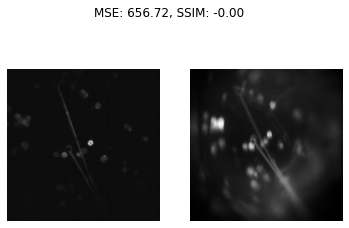

Stored 'twop_im_clean' (ndarray)


In [59]:
shap2 = (400,400)
twop_im_clean = prray(twop_im_cl_cut, shap2, sameSum=False)
twop_im_clean.shape
compare_images(twop_im_clean,fg)
%store twop_im_clean

In [13]:
shap2 = (211,211)
twop_im_down2 = prray(twop_im_cl, shap2, sameSum=False)
twop_im_down2.shape


(211, 211)

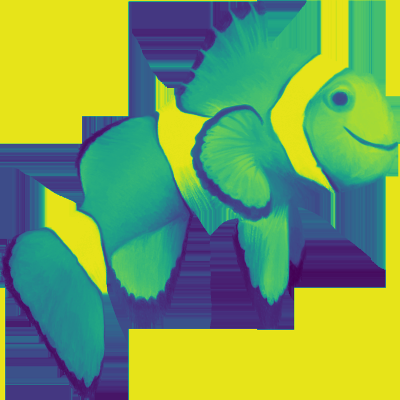

In [129]:
fish_down_im

In [5]:
import matplotlib

Text(0, 0.5, 'error')

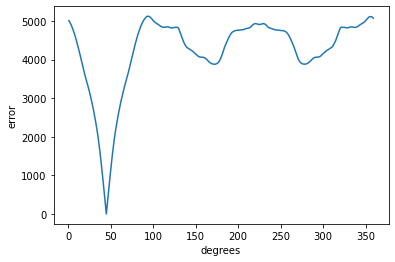

In [11]:
# test image
fish = Image.open("clown.png")
# convert to gray scale
fish_array = np.asarray(fish.convert('L'))
#fish_array = np.asarray(fish)
fish_array.shape
shap_fish = (400,400)
fish_down = prray(fish_array, shap_fish, sameSum=False)
fish_down.shape
matplotlib.image.imsave('fish_down_im.png', fish_down)
fish_down_im = Image.open("fish_down_im.png")
#making rotated image for reference (angle 45)
fish_ref = circle_rotate(fish_down_im, 200, 200, 200, 45)
fish_ref
fish_ref_array = np.asarray(fish_ref.convert('L'))

# checking for other image
fish_list = []
start = 1
finish = 360
for j in range (start,finish):
    i2 = circle_rotate(fish_down_im, 200, 200, 200, j)
    fish_measure = np.asarray(i2.convert('L'))
    a = mse(fish_ref_array,fish_measure)
    fish_list.append(a)
x_axis = list(range(start,finish))
plt.plot(x_axis,fish_list)
plt.xlabel('degrees')
plt.ylabel('error')

In [7]:
# minimum value
storage_fish = list(zip(x_axis,fish_list))
storage1_fish = np.array(storage_fish)
finding_min = np.array(fish_list)
np.argmin(finding_min)
storage1_fish[np.argmin(finding_min),:]

array([45.,  0.])

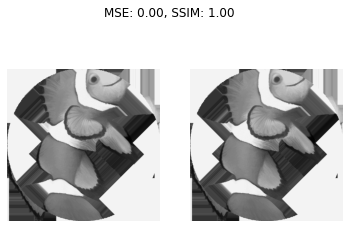

In [9]:
i2 = circle_rotate(fish_down_im, 200, 200, 200, 45)
fish_measure = np.asarray(i2.convert('L'))
compare_images(fish_ref_array,fish_measure)

In [ ]:
i2 = circle_rotate(clean_2p, 200, 200, 200, 5)
two_p_clean = np.asarray(i2.convert('L'))
compare_images(fg,two_p_clean)

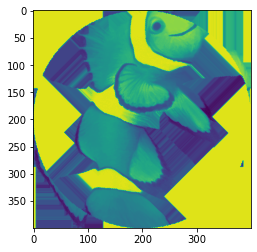

In [143]:
plt.imshow(fish_ref_array)

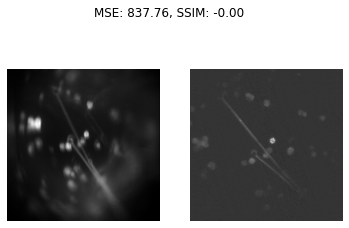

In [148]:
#twop_im_clean
matplotlib.image.imsave('clean_2p_cut.png', twop_im_clean)
clean_2p = Image.open("clean_2p_cut.png")
i2 = circle_rotate(clean_2p, 200, 200, 200, 20)
two_p_clean = np.asarray(i2.convert('L'))
#fg2 = np.asarray(fg.convert('L'))
compare_images(fg,two_p_clean)

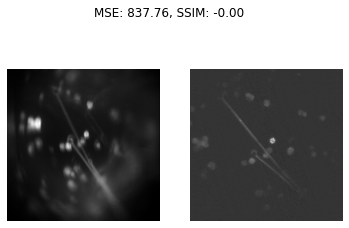

In [72]:
two_p_clean = np.asarray(i2.convert('L'))
compare_images(fg,two_p_clean)

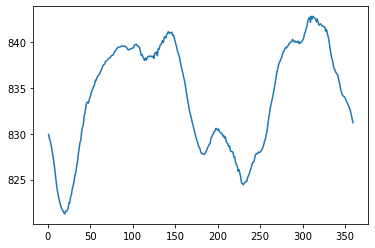

In [98]:
mse_list2 = []
start = 1
finish = 360
for j in range (start,finish):
    i2 = circle_rotate(clean_2p, 105, 105, 105, j)
    two_p_new = np.asarray(i2.convert('L'))
    a = mse(fg,two_p_new)
    mse_list2.append(a)
x_axis = list(range(start,finish))
plt.plot(x_axis,mse_list2)

In [109]:
#gettinig minimum value
storage = list(zip(x_axis,mse_list2))
storage1 = np.array(storage)
# first, find the index of maximum on the unraveled matrix
arg_min = np.argmin(storage1)

# then find back the 2d indexes
m_min, n_min = np.unravel_index(arg_min, storage1.shape)

min(mse_list2)

821.2555804921575

In [111]:
# minimum value
storage = list(zip(x_axis,mse_list2))
storage1 = np.array(storage)
finding_min = np.array(mse_list2)
np.argmin(finding_min)
storage1[np.argmin(finding_min),:]

array([ 20.        , 821.25558049])

In [95]:
import numpy as np
from matplotlib.pyplot import *

#c = np.poly1d(storage)
c = storage1

crit = c.deriv().r
r_crit = crit[crit.imag==0].real
test = c.deriv(2)(r_crit) 


# compute local minima 
# excluding range boundaries
x_min = r_crit[test>0]
y_min = c(x_min)
plot( x_min, y_min, 'o' )

xc = np.arange(-2.5, 2.6, 0.02)
yc = c(xc)
plot( xc, yc)

#xlim([-2.5,2.5])
show()

AttributeError: 'numpy.ndarray' object has no attribute 'deriv'

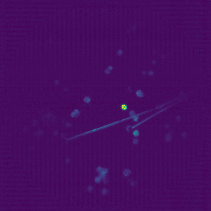

In [26]:
import matplotlib.image

matplotlib.image.imsave('clean_2p.png', twop_im_down2)
clean_2p = Image.open("clean_2p.png")
i2 = circle_rotate(clean_2p, 105, 105, 105, 90)
i2

C:\Users\Katherin\miniconda3\envs\caiman\lib\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


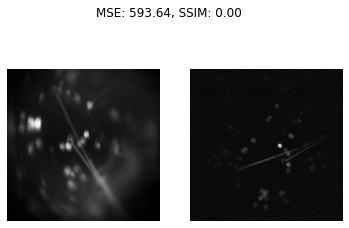

In [24]:
shap2 = (211,211)
fg_down = prray(fg, shap2, sameSum=False)
two_p_clean = np.asarray(i2.convert('L'))
compare_images(fg_down,two_p_clean)

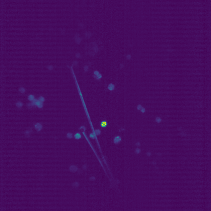

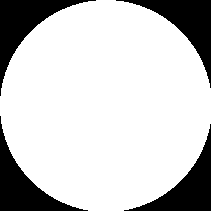

TypeError: Cannot handle this data type: (1, 1, 5), |u1

In [21]:
from PIL import Image, ImageDraw

img = Image.open("clean_2p.png")
display(img)


h,w = img.size
  
# creating luminous image
lum_img = Image.new('L',[h,w] ,0) 
draw = ImageDraw.Draw(lum_img)
draw.pieslice([(0,0),(h,w)],0,360,fill=255)
img_arr = np.array(img)
lum_img_arr = np.array(lum_img)
display(Image.fromarray(lum_img_arr))

final_img_arr = np.dstack((img_arr, lum_img_arr))
display(Image.fromarray(final_img_arr))
#saving into png
im = Image.fromarray(final_img_arr)
im.save('clean_2p_circle.png')

In [49]:
twop_im_down2.shape
h,w = img.size
  
# creating luminous image
lum_img = Image.new('L',[h,w] ,0) 
draw = ImageDraw.Draw(lum_img)
draw.pieslice([(0,0),(h,w)],0,360,fill=255)

lum_img_arr = np.array(twop_im_down2)
display(Image.fromarray(lum_img_arr))

final_img_arr = np.dstack((twop_im_down2, lum_img_arr))
display(Image.fromarray(final_img_arr))

ValueError: Could not save to PNG for display

<PIL.Image.Image image mode=F size=400x400>

TypeError: Cannot handle this data type: (1, 1, 2), <f8

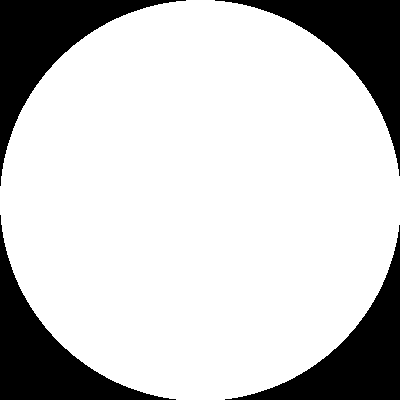

In [58]:

from PIL import Image, ImageDraw





h,w = clened_2p_im.size
  
# creating luminous image
lum_img = Image.new('L',[h,w] ,0) 
draw = ImageDraw.Draw(lum_img)
draw.pieslice([(0,0),(h,w)],0,360,fill=255)
img_arr = np.array(clened_2p_im)
lum_img_arr = np.array(lum_img)
display(Image.fromarray(lum_img_arr))

final_img_arr22 = np.dstack((img_arr, lum_img_arr))


In [61]:
final_img_arr22

array([[[6.728664 , 0.       ],
        [5.887826 , 0.       ],
        [6.704169 , 0.       ],
        ...,
        [6.0902185, 0.       ],
        [6.0041084, 0.       ],
        [6.8280077, 0.       ]],

       [[6.0268426, 0.       ],
        [5.7592244, 0.       ],
        [6.4042244, 0.       ],
        ...,
        [5.9466696, 0.       ],
        [5.8975363, 0.       ],
        [6.127817 , 0.       ]],

       [[5.6877623, 0.       ],
        [5.223605 , 0.       ],
        [5.41711  , 0.       ],
        ...,
        [6.8592453, 0.       ],
        [6.0910654, 0.       ],
        [5.854434 , 0.       ]],

       ...,

       [[7.5852957, 0.       ],
        [7.021082 , 0.       ],
        [7.3276634, 0.       ],
        ...,
        [5.1687407, 0.       ],
        [5.4277806, 0.       ],
        [5.677275 , 0.       ]],

       [[6.519218 , 0.       ],
        [5.818395 , 0.       ],
        [7.018706 , 0.       ],
        ...,
        [6.459925 , 0.       ],
        [6.257962 

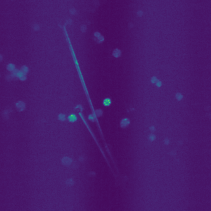

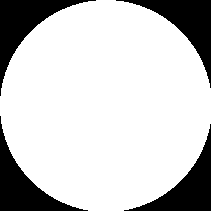

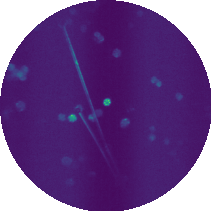

In [39]:
#trying to cropp in a circle and then adjust and rotate
from PIL import Image, ImageDraw

img = Image.open("tes222-Copy1.png")
display(img)


h,w = img.size
  
# creating luminous image
lum_img = Image.new('L',[h,w] ,0) 
draw = ImageDraw.Draw(lum_img)
draw.pieslice([(0,0),(h,w)],0,360,fill=255)
img_arr = np.array(img)
lum_img_arr = np.array(lum_img)
display(Image.fromarray(lum_img_arr))

final_img_arr = np.dstack((img_arr, lum_img_arr))
display(Image.fromarray(final_img_arr))
#saving into png
im = Image.fromarray(final_img_arr)
im.save('new_circle.png')


In [9]:
final_img_arr

array([[[ 71,  20, 102,   0],
        [ 71,  22, 105,   0],
        [ 71,  21, 103,   0],
        ...,
        [ 71,  21, 103,   0],
        [ 71,  22, 105,   0],
        [ 71,  22, 105,   0]],

       [[ 71,  22, 105,   0],
        [ 71,  21, 103,   0],
        [ 71,  20, 102,   0],
        ...,
        [ 71,  24, 106,   0],
        [ 71,  22, 105,   0],
        [ 72,  25, 107,   0]],

       [[ 71,  22, 105,   0],
        [ 71,  20, 102,   0],
        [ 71,  20, 102,   0],
        ...,
        [ 71,  22, 105,   0],
        [ 71,  24, 106,   0],
        [ 71,  22, 105,   0]],

       ...,

       [[ 71,  20, 102,   0],
        [ 71,  20, 102,   0],
        [ 71,  20, 102,   0],
        ...,
        [ 71,  22, 105,   0],
        [ 71,  20, 102,   0],
        [ 71,  21, 103,   0]],

       [[ 71,  20, 102,   0],
        [ 71,  21, 103,   0],
        [ 71,  21, 103,   0],
        ...,
        [ 71,  21, 103,   0],
        [ 71,  22, 105,   0],
        [ 71,  21, 103,   0]],

       [[ 71

In [ ]:
image = cv2.imread("circle_test1.png")

(h, w) = image.shape[:2]
center = (w / 2, h / 2)
angle = 20
scale = 1

M = cv2.getRotationMatrix2D(center, angle, scale)
rotated = cv2.warpAffine(image, M, (w, h))

cv2.imshow('original Image', image)
cv2.imshow('Rotated Image', rotated)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [5]:
import numpy

In [30]:
def circle_rotate(image, x, y, radius, degree):
    img_arr = numpy.asarray(image)
    box = (x-radius, y-radius, x+radius+1, y+radius+1)
    crop = image.crop(box=box)
    crop_arr = numpy.asarray(crop)
    # build the cirle mask
    mask = numpy.zeros((2*radius+1, 2*radius+1))
    for i in range(crop_arr.shape[0]):
        for j in range(crop_arr.shape[1]):
            if (i-radius)**2 + (j-radius)**2 <= radius**2:
                mask[i,j] = 1
    # create the new circular image
    sub_img_arr = numpy.empty(crop_arr.shape ,dtype='uint8')
    sub_img_arr[:,:,:3] = crop_arr[:,:,:3]
    sub_img_arr[:,:,3] = mask*255
    sub_img = Image.fromarray(sub_img_arr, "RGBA").rotate(degree)
    i2 = image.copy()
    #going back to whole image
    i2.paste(sub_img, box[:2], sub_img.convert('RGBA'))
    return i2



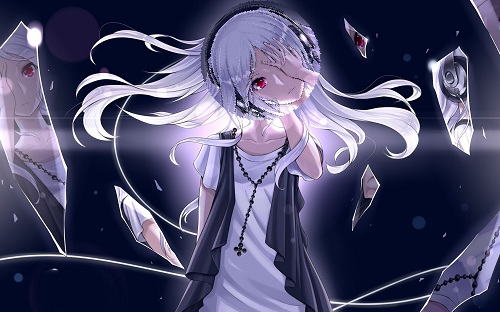

In [33]:
i2 = circle_rotate(img2, 260, 60, 60, 45)
i2

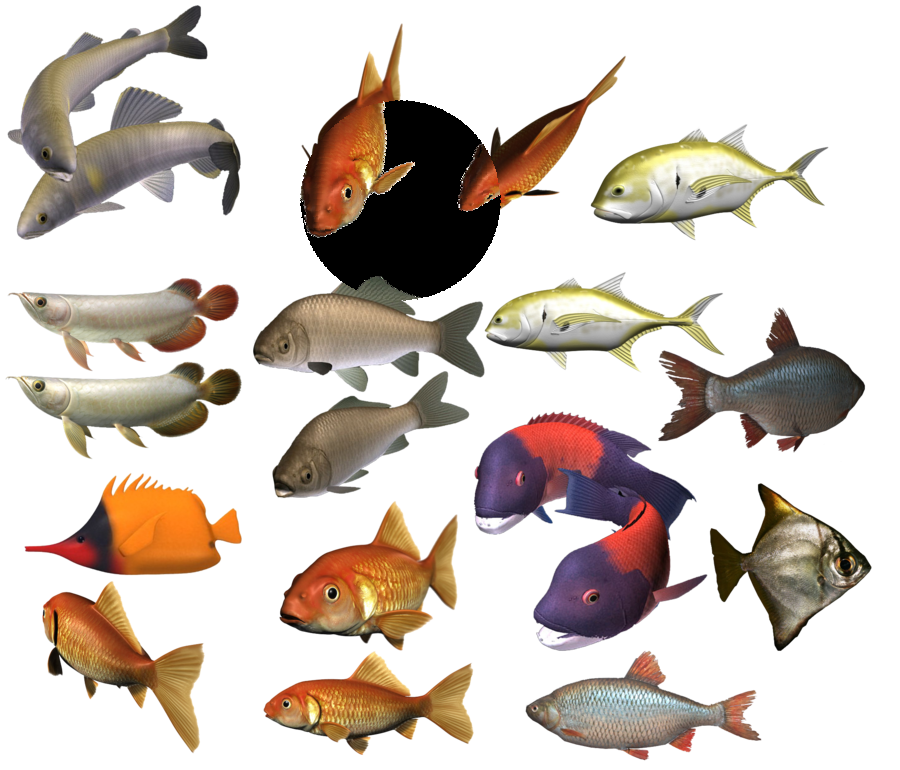

In [48]:
i2 = circle_rotate(img4, 400, 200, 300, 10)
i2

In [17]:
img2 = Image.open("PxGtN.png")
#sub_image = img.crop(box=(50,20,70,80)).rotate(90)
#img.paste(sub_image, box=(200,0))
#img

In [5]:
img3 = Image.open("circle_test1.png")
img3.size

(211, 211)

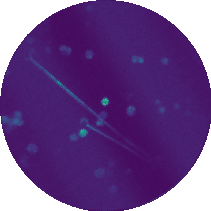

In [10]:
i2 = circle_rotate(img3, 105, 105, 105, 30)
i2

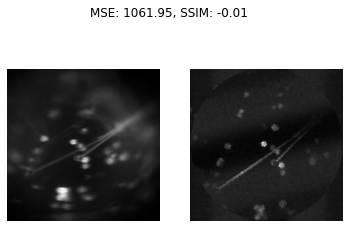

In [30]:
i2 = circle_rotate(img3, 105, 105, 105, 105)
two_p_new = np.asarray(i2.convert('L'))
compare_images(minisc_down3_reflected,two_p_new)

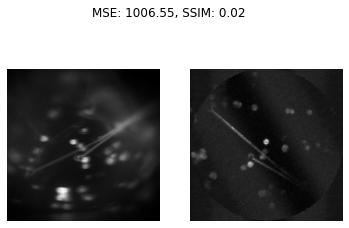

In [42]:
i2 = circle_rotate(img3, 105, 105, 105, 30)
two_p_new = np.asarray(i2.convert('L'))
compare_images(minisc_down3_reflected,two_p_new)

In [31]:
i2 = circle_rotate(img3, 105, 105, 105, 105)
two_p_new = np.asarray(i2.convert('L'))
mse(minisc_down3_reflected,two_p_new)

1061.9521176418195

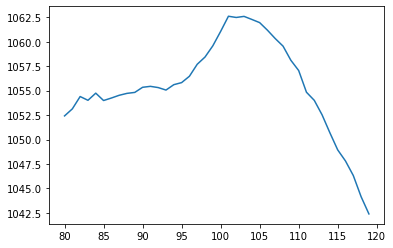

In [43]:
mse_list2 = []
start = 80
finish = 120
for j in range (start,finish):
    i2 = circle_rotate(img3, 105, 105, 105, j)
    two_p_new = np.asarray(i2.convert('L'))
    a = mse(minisc_down3_reflected,two_p_new)
    mse_list2.append(a)
x_axis = list(range(start,finish))
plt.plot(x_axis,mse_list2)

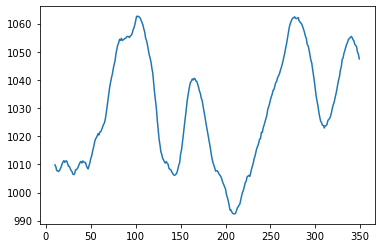

In [40]:
mse_list2 = []
start = 10
finish = 350
for j in range (start,finish):
    i2 = circle_rotate(img3, 105, 105, 105, j)
    two_p_new = np.asarray(i2.convert('L'))
    a = mse(minisc_down3_reflected,two_p_new)
    mse_list2.append(a)
x_axis = list(range(start,finish))
plt.plot(x_axis,mse_list2)

In [ ]:
# setting empty list and appropriate array filled with zeros
mse_list1 = []
arr1 = np.zeros((30,30), dtype="float32")


for j in range (0,30):
    for i in range (0,30):
            arr1[j,i] = mse(sliced_stack_b1[i,10:350,115:350], sliced_stack_b1[j, 10:350,115:350]) # included cropping
#plot each slide compared to every slide with colorbar

plt.imshow(arr1,cmap='gist_heat')
plt.title("error between slides")
plt.colorbar()


In [65]:
i2.save('new_image.png')

In [11]:
img5 = Image.open("new_image.png")
img5.size

(211, 211)

In [20]:
img2.size

(500, 312)

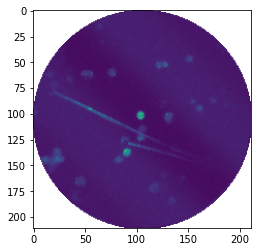

In [78]:
plt.imshow(two_p)

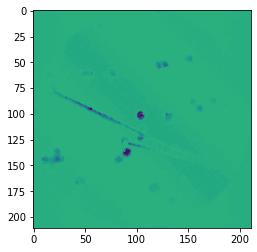

In [80]:
plt.imshow(two_p_lessdim)

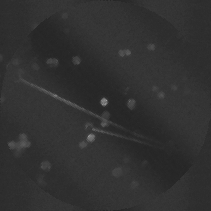

In [13]:

img6 = img5.convert('L') #to black and white
two_p = np.asarray(img6)
two_p.shape
img6

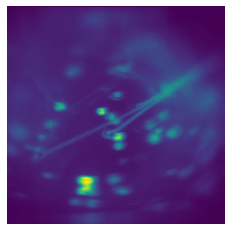

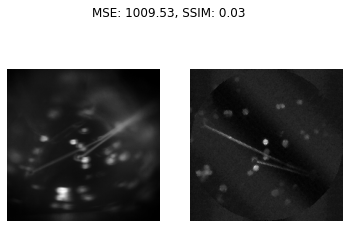

In [15]:

shap3 = (211,211)
minisc_down3 = prray(minisc_im_nocut, shap3, sameSum=False)
#two_p = numpy.asarray(img5)
minisc_down3_reflected = reflect_x_axis(minisc_down3)
#two_p_lessdim = two_p[:, :, 0]

compare_images(minisc_down3_reflected,two_p)

In [ ]:
mse(imageA, imageB)

In [17]:
img_arr = np.asarray(img)
img_arr.shape

(211, 211, 3)

In [12]:
i2 = circle_rotate(img2, 260, 60, 60, 45)
i2

ValueError: buffer is not large enough

In [9]:
import matplotlib.image

matplotlib.image.imsave('circle_test1.png', final_img_arr)

In [12]:
def rotate2(image, angle, center = None, scale = 1.0):
    (h, w) = image.shape[:2]

    if center is None:
        center = (w / 2, h / 2)

    # Perform the rotation
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))

    return rotated

In [16]:
img = Image.open("tes222-Copy1.png")
rotate2(img,'90')

AttributeError: shape

In [20]:
#pip install imutils
skimage.transform.rotate(final_img_arr,2)

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       ...,

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0.

In [13]:
import skimage

display(Image.fromarray(skimage.transform.rotate(final_img_arr,45)))

AttributeError: 'NoneType' object has no attribute 'fromarray'

In [15]:
pip install pygame

     ---------------------------------------- 8.4/8.4 MB 4.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [12]:
rotate_center(twop_im_down2,10)

TypeError: Can't convert object to 'str' for 'filename'

In [6]:
def rot_center(image, angle):
    """rotate a Surface, maintaining position."""
    
    loc = image.get_rect().center  #rot_image is not defined 
    rot_sprite = pygame.transform.rotate(image, angle)
    rot_sprite.get_rect().center = loc
    return rot_sprite
    
    # or return tuple: (Surface, Rect)
    # return rot_sprite, rot_sprite.get_rect()

In [11]:
def rotate_center(img, angle):
    img = cv2.imread(img)
    (height, width) = img.shape[:2]
    (cent_x, cent_y) = (width // 2, height // 2)

    mat = cv2.getRotationMatrix2D((cent_x, cent_y), -angle, 1.0)
    cos = np.abs(mat[0, 0])
    sin = np.abs(mat[0, 1])

    n_width = int((height * sin) + (width * cos))
    n_height = int((height * cos) + (width * sin))

    mat[0, 2] += (n_width / 2) - cent_x
    mat[1, 2] += (n_height / 2) - cent_y

    return cv2.warpAffine(img, mat, (n_width, n_height))

In [10]:
shap2 = (400,400)
twop_im_down = prray(twop_im_cl, shap2, sameSum=False)

compare_images(twop_im_down,fg)

NameError: name 'fg' is not defined

no stored variable or alias #
no stored variable or alias get
no stored variable or alias the
no stored variable or alias image
no stored variable or alias from
no stored variable or alias the
no stored variable or alias storage


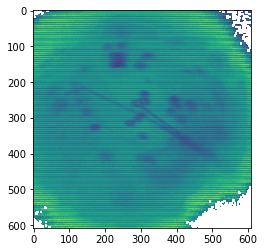

In [15]:
%store -r CI # get the image from the storage

plt.imshow(CI)

In [16]:
CIr = CI[48:560,48:560]


In [ ]:
angle = 45
size = 512, 512

dst_im = Image.new("RGBA", (196,283), "blue" )
im = src_im.convert('RGBA')
rot = im.rotate( angle, expand=1 ).resize(size)
dst_im.paste( rot, (50, 50), rot )
dst_im.save("test.png")

In [11]:
mse(minisc_cut_im2,twop_im)

664.4321850657697

C:\Users\Katherin\miniconda3\envs\caiman\lib\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


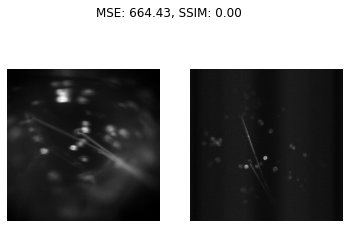

In [12]:
compare_images(minisc_cut_im2,twop_im,'miniscope vs 2P')

In [44]:
mse(minisc_cut_im2,twop_im)

664.4321850657697

C:\Users\Katherin\miniconda3\envs\caiman\lib\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


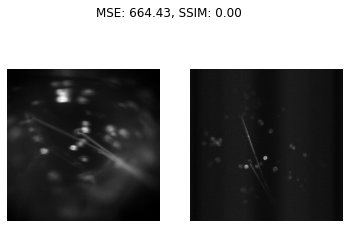

In [9]:
compare_images(minisc_im_nocut,twop_im)

In [13]:
compare_images(fg2,twop_im_croptest)

NameError: name 'fg2' is not defined

In [14]:
twop_im_croptest.shape

NameError: name 'twop_im_croptest' is not defined

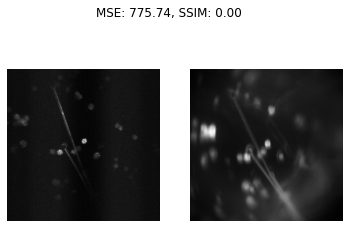

Stored 'twop_im_croptest_down' (ndarray)


In [30]:
shap2 = (350,350)
twop_im_croptest_down = prray(twop_im_croptest, shap2, sameSum=False)
compare_images(twop_im_croptest_down,fg2)
%store twop_im_croptest_down

In [33]:
np.save('fg2.npy',fg2)

In [53]:
import cv2
import numpy as np

image = cv2.imread( "tes222-Copy1.png")

#convert to gray
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#performing binary thresholding
kernel_size = 3
ret,thresh = cv2.threshold(gray,200,255,cv2.THRESH_BINARY)  

#finding contours 
cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

#drawing Contours
radius =2
color = (30,255,50)
cv2.drawContours(image, cnts, -1,color , radius)
# cv2.imshow(image) commented as colab don't support cv2.imshow()
cv2.imshow(image)
# cv2.waitKey()

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'imshow'
> Overload resolution failed:
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)


In [49]:
import poly_point_isect

ModuleNotFoundError: No module named 'poly_point_isect'

In [48]:
#getting lines to adjust images
import poly_point_isect as bot
img = cv2.imread('tes222-Copy1.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 50  # minimum number of pixels making up a line
max_line_gap = 20  # maximum gap in pixels between connectable line segments
line_image = np.copy(img) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)
print(lines)
points = []
for line in lines:
    for x1, y1, x2, y2 in line:
        points.append(((x1 + 0.0, y1 + 0.0), (x2 + 0.0, y2 + 0.0)))
        cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 5)

lines_edges = cv2.addWeighted(img, 0.8, line_image, 1, 0)
print(lines_edges.shape)
#cv2.imwrite('line_parking.png', lines_edges)

print(points)
intersections = bot.isect_segments(points)
print(intersections)

for inter in intersections:
    a, b = inter
    for i in range(3):
        for j in range(3):
            lines_edges[int(b) + i, int(a) + j] = [0, 255, 0]

cv2.imwrite('line_parking.png', lines_edges)


ModuleNotFoundError: No module named 'poly_point_isect'

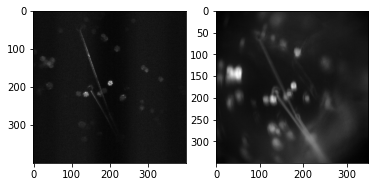

Stored 'twop_im_croptest' (ndarray)


In [24]:
#plt.imshow(twop_im[110:512,50:450])
twop_im_croptest = twop_im[110:510,50:450]
twop_im_croptest.shape
#plt.imshow(twop_im_croptest)
#plt.imshow(rotated_nocut_img2)
fg2 = fg[0:350,30:380]
fig, (ax1, ax2) = plt.subplots(1, 2)
im1 = ax1.imshow(twop_im_croptest, cmap ="gray")
im2 = ax2.imshow(fg2, cmap ="gray")
plt.show()
fg2.shape
%store twop_im_croptest

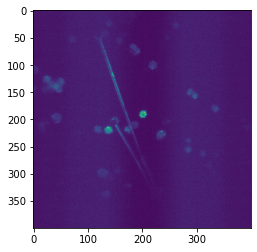

In [74]:
im = Image.fromarray(twop_im_croptest)
#im.save('test_2p.png')
plt.imshow(twop_im_croptest) 
plt.savefig("test_2p")

In [81]:
# Opens a image in RGB mode
im = Image.open('C:/Users/Katherin/Documents/caiman/test_2p.png')
 
# Size of the image in pixels (size of original image)
# (This is not mandatory)
width, height = im.size
 
# Setting the points for cropped image
top = 10
bottom = 100
left = 200
right = 200
 
# Cropped image of above dimension
# (It will not change original image)
im1 = im.crop((left, top, right, bottom))
 
# Shows the image in image viewer
im1.show()

SystemError: tile cannot extend outside image

In [78]:
im.size

(432, 288)

In [45]:
shap = (400,400)
fg3 = prray(fg2, shap, sameSum=False)
fg3.shape

(400, 400)

In [50]:
%store fg

Stored 'fg' (ndarray)


In [15]:
%store -r fg

In [53]:
! git clone https://github.com/peng-lab/PyBaSiC.git

Cloning into 'PyBaSiC'...
Updating files:  40% (153/379)
Updating files:  41% (156/379)
Updating files:  42% (160/379)
Updating files:  43% (163/379)
Updating files:  44% (167/379)
Updating files:  45% (171/379)
Updating files:  46% (175/379)
Updating files:  47% (179/379)
Updating files:  48% (182/379)
Updating files:  49% (186/379)
Updating files:  50% (190/379)
Updating files:  51% (194/379)
Updating files:  52% (198/379)
Updating files:  53% (201/379)
Updating files:  54% (205/379)
Updating files:  55% (209/379)
Updating files:  56% (213/379)
Updating files:  57% (217/379)
Updating files:  58% (220/379)
Updating files:  59% (224/379)
Updating files:  60% (228/379)
Updating files:  60% (230/379)
Updating files:  61% (232/379)
Updating files:  62% (235/379)
Updating files:  63% (239/379)
Updating files:  64% (243/379)
Updating files:  65% (247/379)
Updating files:  66% (251/379)
Updating files:  67% (254/379)
Updating files:  68% (258/379)
Updating files:  69% (262/379)
Updating file

In [57]:
np.save('twop_im_croptest.npy',twop_im_croptest)

In [7]:
import pybasic

In [98]:
new_path = 'C:/Users/Katherin/Documents/caiman/pbasic3'
brightfield_images = pybasic.tools.load_data(new_path, file_ext = ".png", verbosity = True)

0 / 1


In [97]:
import cv2
image = cv2.imread('C:/Users/Katherin/Documents/caiman/pbasic2/test_2p22.png')
 
y=0
x=0
h=211
w=211
crop_image = image[x:w, y:h]
cv2.imshow("Cropped", crop_image)
cv2.waitKey(0)
cv2.imwrite('C:/Users/Katherin/Documents/caiman/pbasic2/tes222.png', crop_image)

True

In [62]:
new_path = 'C:/Users/Katherin/Documents/caiman/pbasic2'
brightfield_images = pybasic.tools.load_data(new_path, file_ext = ".tif", verbosity = False)

In [99]:
flatfield, darkfield = pybasic.basic(brightfield_images, darkfield=True)

reweighting_iter: 1
reweighting_iter: 2
reweighting_iter: 3
reweighting_iter: 4
reweighting_iter: 5
reweighting_iter: 6
reweighting_iter: 7
reweighting_iter: 8
reweighting_iter: 9
reweighting_iter: 10


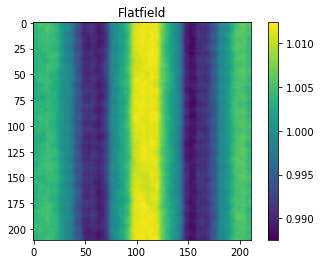

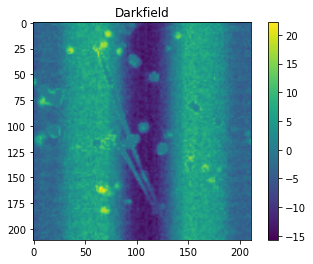

In [100]:
plt.title('Flatfield')
plt.imshow(flatfield)
plt.colorbar()
plt.show()
plt.title('Darkfield')
plt.imshow(darkfield)
plt.colorbar()
plt.show()

In [101]:
flatfield, darkfield = pybasic.basic(brightfield_images, darkfield=True)

reweighting_iter: 1
reweighting_iter: 2
reweighting_iter: 3
reweighting_iter: 4
reweighting_iter: 5
reweighting_iter: 6
reweighting_iter: 7
reweighting_iter: 8
reweighting_iter: 9
reweighting_iter: 10


In [102]:
baseflour = pybasic.background_timelapse(
    images_list = brightfield_images, 
    flatfield = flatfield, 
    darkfield = darkfield
)

reweighting_iter: 1
reweighting_iter: 2
reweighting_iter: 3
reweighting_iter: 4
reweighting_iter: 5


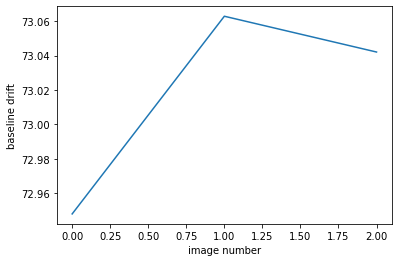

In [103]:
plt.plot(baseflour)
plt.ylabel("baseline drift")
plt.xlabel("image number")
plt.show()

In [114]:
test = np.zeros([1, 211,211,3])
test[0, :,:,0] = flatfield
test2 = np.zeros([1, 211,211,3])
test[0, :,:,0] = darkfield

In [116]:
#
np.shape(brightfield_images)
np.shape(test)

(1, 211, 211, 3)

In [113]:
pybasic.correct_illumination?

In [117]:
brightfield_images_corrected = pybasic.correct_illumination(
    images_list = brightfield_images, 
    flatfield = test, 
    darkfield = test2,
    background_timelapse = baseflour
)

#brightfield_images
#darkfield
#flatfield
#baseflour

ValueError: output_shape length cannot be smaller than the image number of dimensions

In [32]:


plt.imshow(images[22])


IndexError: list index out of range

In [31]:
images.shape

AttributeError: 'list' object has no attribute 'shape'

In [22]:
compare_images(twop_im_croptest,fg)

NameError: name 'twop_im_croptest' is not defined

In [73]:
!pip install xarray

     -------------------------------------- 927.2/927.2 kB 9.9 MB/s eta 0:00:00


In [10]:
#function for downsampling into desirable shape

import math
import scipy
def prray(inArray, finalShape, sameSum=False, **zoomKwargs):
    inArray = np.asarray(inArray, dtype = np.double)
    inShape = inArray.shape
    assert len(inShape) == len(finalShape)
    mults = []
    for i in range(len(inShape)):
        if finalShape[i] < inShape[i]:
            mults.append(int(np.ceil(inShape[i]/finalShape[i])))
        else:
            mults.append(1)
    tempShape = tuple([i * j for i,j in zip(finalShape, mults)])

    zoomMultipliers = np.array(tempShape) / np.array(inShape) + 0.0000001
    rescaled = scipy.ndimage.zoom(inArray, zoomMultipliers, **zoomKwargs)

    for ind, mult in enumerate(mults):
        if mult != 1:
            sh = list(rescaled.shape)
            assert sh[ind] % mult == 0
            newshape = sh[:ind] + [sh[ind] / mult, mult] + sh[ind+1:]
            rescaled.shape = list(map(int, newshape))
            rescaled = np.mean(rescaled, axis = ind+1)
    assert rescaled.shape == finalShape

    if sameSum:
        extraSize = np.prod(finalShape) / np.prod(inShape)
        rescaled /= extraSize
    return rescaled


In [20]:
shap = (400,400)
fg = prray(rotated_nocut_img2, shap, sameSum=False)
fg.shape

(400, 400)

In [21]:
shap = (400,400)
fg2 = prray(fg, shap, sameSum=False)
fg2.shape

(400, 400)

In [127]:
down_sampled.shape

(256, 256)

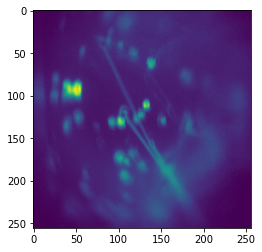

In [21]:
down_sampled=rotated_nocut_img2[0::2,0::2]
down_sampled.shape
plt.imshow(down_sampled)

TypeError: float() argument must be a string or a number, not 'DataArrayCoarsen'

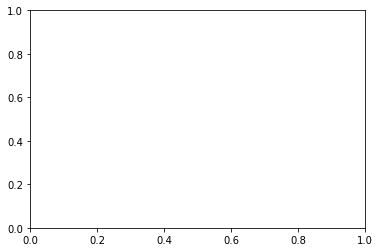

In [94]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Create a 10x10 array of random numbers
a = xr.DataArray(rotated_nocut_img2, dims=['x', 'y'])

# "Downscale" the array, mean of blocks of size (2x2)
b = a.coarsen(x=400, y=400)

miniscope_new = np.array(b)
miniscope_new.shape
plt.plot(miniscope_new)

In [149]:
twop_im_croptest.shape

(400, 400)

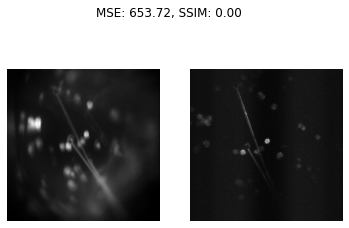

In [150]:
compare_images(fg,twop_im_croptest)

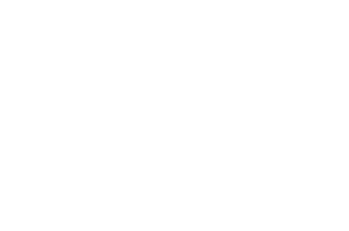

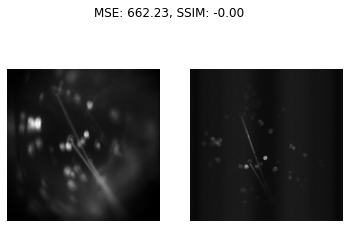

Stored 'rotated_nocut_img2' (ndarray)


In [18]:

  # REFLECTING 
plt.axis('off')
rows, cols = minisc_im_nocut.shape
# transformation matrix for x-axis reflection 
M = np.float32([[1,  0, 0   ],
                [0, -1, rows],
                [ 0, 0, 1   ]])
reflected_nocut_img = cv2.warpPerspective(minisc_im_nocut,M,(int(cols),int(rows)))
# disable x & y axis
plt.axis('off')

# rotating
rotated_nocut_img = Image.fromarray(np.rot90(reflected_nocut_img,3))
np.save('rotated_nocut_img',rotated_nocut_img)
rotated_nocut_img2 = np.load('rotated_nocut_img.npy')
#comparing
compare_images(rotated_nocut_img2,twop_im)
%store rotated_nocut_img2

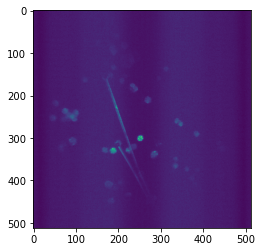

In [15]:
plt.imshow(twop_im)

array([[0.        , 3.86666667, 3.76666667, ..., 5.63333333, 4.56666667,
        4.53333333],
       [0.        , 4.5       , 5.26666667, ..., 4.33333333, 3.66666667,
        3.53333333],
       [0.        , 2.63333333, 3.1       , ..., 4.7       , 3.76666667,
        4.96666667],
       ...,
       [0.        , 5.33333333, 4.13333333, ..., 3.96666667, 3.7       ,
        2.96666667],
       [0.        , 3.8       , 3.03333333, ..., 6.4       , 4.9       ,
        4.56666667],
       [0.        , 4.96666667, 4.56666667, ..., 3.56666667, 3.33333333,
        2.73333333]])

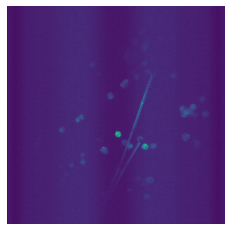

In [27]:
reflect_y_axis(twop_im)

In [28]:
def reflect_x_axis(image):
    plt.axis('off')
    rows, cols = image.shape
    M = np.float32([[1,  0, 0   ],
                    [0, -1, rows],
                    [ 0, 0, 1   ]])
    image_reflected = cv2.warpPerspective(image,M,(int(cols),int(rows)))
    plt.axis('off')
    plt.imshow(image_reflected)
    return image_reflected
def reflect_y_axis(image):
    plt.axis('off')
    rows, cols = image.shape
    M = np.float32([[-1,  0, cols   ],
                    [0, 1, 0],
                    [ 0, 0, 1   ]])
    image_reflected = cv2.warpPerspective(image,M,(int(cols),int(rows)))
    plt.axis('off')
    plt.imshow(image_reflected)
    return image_reflected

In [26]:
def reflect_y_axis(image):
    plt.axis('off')
    rows, cols = image.shape
    M = np.float32([[-1,  0, cols   ],
                    [0, 1, 0],
                    [ 0, 0, 1   ]])
    image_reflected = cv2.warpPerspective(image,M,(int(cols),int(rows)))
    plt.axis('off')
    plt.imshow(image_reflected)
    return image_reflected

In [ ]:
def mse(imageA, imageB):
# the 'Mean Squared Error' between the two images is the
# sum of the squared difference between the two images;
# NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])

# return the MSE, the lower the error, the more "similar"
# the two images are
    return err

def reflect(image):
    plt.axis('off')
    rows, cols = image.shape
    # transformation matrix for x-axis reflection 
    M = np.float32([[1,  0, 0   ],
                    [0, -1, rows],
                    [ 0, 0, 1   ]])
    image_reflected = cv2.warpPerspective(image,M,(int(cols),int(rows)))
    # disable x & y axis
    plt.axis('off')
    plt.imshow(image_reflected)
    return image_reflected



def reflect(im):
    plt.axis('off')
    rows, cols = minisc_im_nocut.shape
    # transformation matrix for x-axis reflection 
    M = np.float32([[1,  0, 0   ],
                    [0, -1, rows],
                    [ 0, 0, 1   ]])
    reflected_nocut_img = cv2.warpPerspective(minisc_im_nocut,M,(int(cols),int(rows)))
    # disable x & y axis
    plt.axis('off')

    # rotating
    rotated_nocut_img = Image.fromarray(np.rot90(reflected_nocut_img,3))
    np.save('rotated_nocut_img',rotated_nocut_img)
    rotated_nocut_img2 = np.load('rotated_nocut_img.npy')
    #comparing
    compare_images(rotated_nocut_img2,twop_im)
    return im_reflected


C:\Users\Katherin\miniconda3\envs\caiman\lib\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


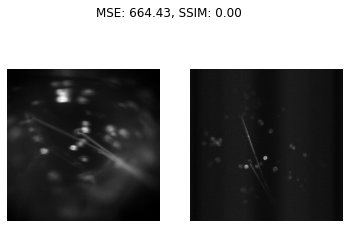

In [10]:
compare_images(minisc_cut_im2,twop_im)

NameError: name 'minisc_cut_im2' is not defined

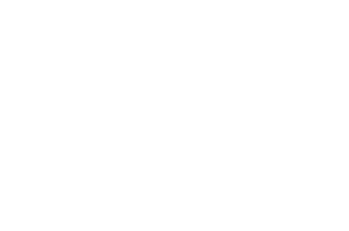

In [17]:
  # REFLECTING 
    
    # read the input image
#img = cv2.imread('minisc_cut_im2')
   # convert from BGR to RGB so we can plot using matplotlib
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
   # disable x & y axis
plt.axis('off')
# show the image
plt.imshow(minisc_cut_im2)
plt.show()
# get the image shape
rows, cols = minisc_cut_im2.shape
# transformation matrix for x-axis reflection 
M = np.float32([[1,  0, 0   ],
                [0, -1, rows],
                [ 0, 0, 1   ]])
# transformation matrix for y-axis reflection
# M = np.float32([[-1, 0, cols],
#                 [ 0, 1, 0   ],
#                 [ 0, 0, 1   ]])
# apply a perspective transformation to the image
reflected_img = cv2.warpPerspective(minisc_cut_im2,M,(int(cols),int(rows)))
# disable x & y axis
plt.axis('off')
# show the resulting image
plt.imshow(reflected_img)
plt.show()

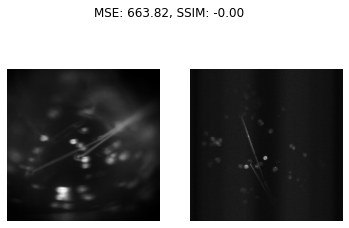

In [12]:
compare_images(reflected_img,twop_im)

NameError: name 'reflected_img' is not defined

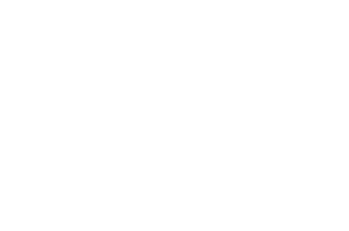

In [16]:
# disable x & y axis
plt.axis('off')
# show the image
plt.imshow(reflected_img)
plt.show()
# get the image shape
rows, cols = reflected_img.shape
#angle from degree to radian
angle = np.radians(1.570796)
#transformation matrix for Rotation
M = np.float32([[np.cos(angle), -(np.sin(angle)), 0],
            	[np.sin(angle), np.cos(angle), 0],
            	[0, 0, 1]])
# apply a perspective transformation to the image
rotated_img = cv2.warpPerspective(reflected_img, M, (int(cols),int(rows)))
# disable x & y axis
plt.axis('off')
# show the resulting image
plt.imshow(rotated_img)
plt.show()

In [15]:


# ROTATING 90
from PIL import Image
plt.imshow(reflected_img)
plt.show()
rotated_img = Image.fromarray(np.rot90(reflected_img,3))
plt.imshow(rotated_img)
plt.show()
np.save('rotated_img',rotated_img)
rotated_img2 = np.load('rotated_img.npy')
compare_images(rotated_img2,twop_im)

NameError: name 'reflected_img' is not defined

In [19]:
compare_images(rotated_img2,twop_im)

NameError: name 'rotated_img2' is not defined

In [11]:
sliced_stack_b1[2,10:350,115:350].dtype

dtype('<u2')

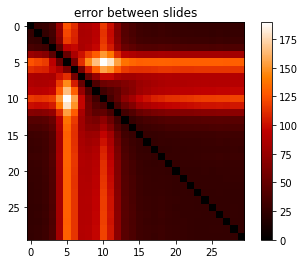

In [8]:


# setting empty list and appropriate array filled with zeros
mse_list1 = []
arr1 = np.zeros((30,30), dtype="float32")


for j in range (0,30):
    for i in range (0,30):
            arr1[j,i] = mse(sliced_stack_b1[i,10:350,115:350], sliced_stack_b1[j, 10:350,115:350]) # included cropping
#plot each slide compared to every slide with colorbar

plt.imshow(arr1,cmap='gist_heat')
plt.title("error between slides")
plt.colorbar()


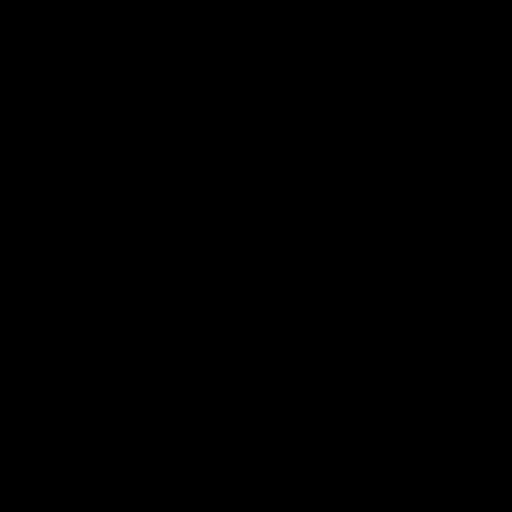

In [16]:
# computatio of correlation within 2P Z-stacks to estimate overlaping within 2P and to get that pecentage. 
# this hopefully would allow to understand which deepness we should use

# to do this we are converting tiff files to images to be able to aply correlation on them

im74 = Image.open('D:/20220623_PollenBrain1/ZSeries-06232022-1119-043/ZSeries-06232022-1119-043_Cycle00001_Ch2_000074.ome.tif')
im74


In [17]:
I = plt.imread('D:/20220623_PollenBrain1/ZSeries-06232022-1119-043/ZSeries-06232022-1119-043_Cycle00001_Ch2_000040.ome.tif')
I

array([[ 2,  6,  1, ...,  4,  1,  2],
       [ 2,  0,  5, ...,  1,  1, 10],
       [ 4,  4,  1, ...,  6,  4,  4],
       ...,
       [ 2,  1, 11, ...,  7,  3,  7],
       [ 4,  1,  5, ...,  0,  7,  9],
       [ 0,  2,  1, ...,  2,  7,  4]], dtype=uint16)

In [ ]:
pip install GDAL

In [13]:
import skimage.io as skio
import matplotlib.pyplot as plt

In [19]:
# importing tiff stacks as arrays
imstack1 = skio.imread("test_25_frames.tif", plugin="tifffile") 


5.444389343261719


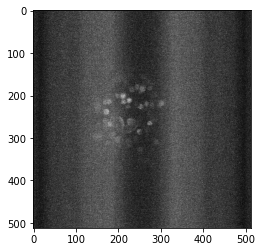

In [20]:
print( imstack1.mean() )
plt.imshow(imstack1[15,:,:], cmap ="gray")
plt.show()

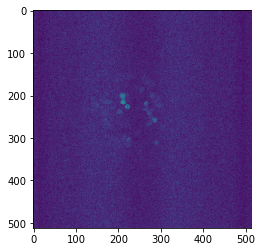

In [21]:
# taking single slices as matrices
im1 = imstack1[1,:,:]
im2 = imstack1[26,:,:]
 
# getting rid of stripes 
imstack2 = imstack1 - np.min(imstack1,axis = 0) # new stack without minimum 
plt.imshow(np.min(imstack1,axis = 0))

plt.imshow(imstack2[20,:,:])

In [6]:
# computation of sum of squared errors, which is working, but we still need to normalise it

def mse(imageA, imageB):
# the 'Mean Squared Error' between the two images is the
# sum of the squared difference between the two images;
# NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])

# return the MSE, the lower the error, the more "similar"
# the two images are
    return err

In [13]:
mse(im1,im2)

5.287097930908203

In [7]:
# function for mean squared error and structural similarity for two pictures

def compare_images(imageA, imageB, title = 'Comparison'):
# compute the mean squared error and structural similarity
# index for the images
    m = mse(imageA, imageB)
    s = ssim(imageA, imageB)
# setup the figure
    fig = plt.figure(title)
    plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))
# show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(imageA, cmap = plt.cm.gray)
    plt.axis("off")
# show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(imageB, cmap = plt.cm.gray)
    plt.axis("off")
# show the images
    plt.show()

In [42]:
#we need to specify axis to work with ndarrays
def mse2(imageA, imageB):
# the 'Mean Squared Error' between the two images is the
# sum of the squared difference between the two images;
# NOTE: the two images must have the same dimension
    err = np.sum(((imageA - imageB) ** 2).mean(axis=0))
    err /= float(imageA.shape[0] * imageA.shape[1])

# return the MSE, the lower the error, the more "similar"
# the two images are
    return err

In [43]:

def compare_images2(imageA, imageB, title='Comparison'):
# compute the mean squared error and structural similarity
# index for the images
    m = mse2(imageA, imageB)
    s = ssim(imageA, imageB)
# setup the figure
    fig = plt.figure(title)
    plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))
# show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(imageA, cmap = plt.cm.gray)
    plt.axis("off")
# show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(imageB, cmap = plt.cm.gray)
    plt.axis("off")
# show the images
    plt.show()

In [34]:
mse2(CIr,twop_im)

nan

In [31]:
compare_images2(CIr,twop_im,'miniscope vs twoP')

AxisError: axis 0 is out of bounds for array of dimension 0

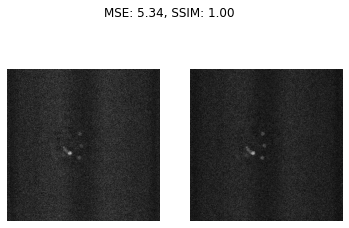

In [33]:
compare_images(imstack2[1,:,:],imstack2[2,:,:],'small_difference')

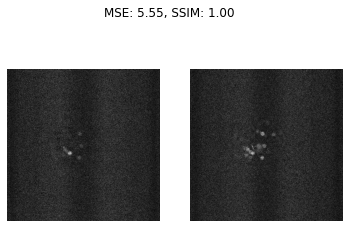

In [37]:
compare_images(imstack2[1,:,:],imstack2[7,:,:],'small_difference')

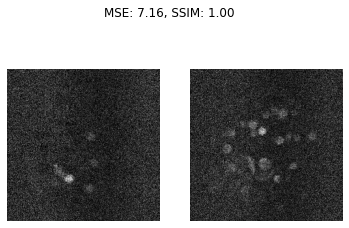

In [44]:
# we cropped images to get better MSE values
compare_images(imstack2[1,115:350,115:350],imstack2[14,115:350,115:350],'small_difference')

C:\Users\Katherin\miniconda3\envs\caiman\lib\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


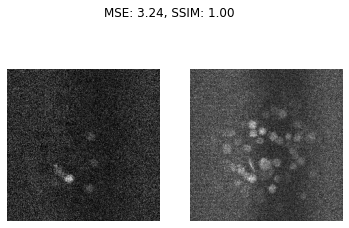

In [50]:
# comparing with mean stack
compare_images(imstack2[1,115:350,115:350],mean_stack[115:350,115:350],'small_difference')



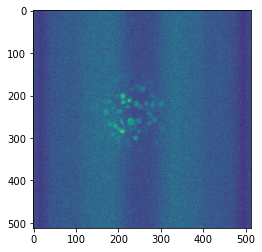

In [23]:
# we created a mean stack to compare it with everything
mean_stack = np.mean(imstack2,axis = 0)
plt.imshow(np.mean(imstack2,axis = 0))

In [24]:
mse_list = []
for i in range (0,25):
        s = mse(imstack2[i,115:350,115:350], mean_stack[115:350,115:350])
        mse_list.append(s)


In [26]:
mse_list = []
for i in range (0,25):
        s = mse(imstack2[i,115:350,115:350], imstack2[12, 115:350,115:350])
        mse_list.append(s)


In [27]:
mse_list

[6.845830692621096,
 7.06518786781349,
 7.171045722046174,
 7.054775916704391,
 7.33117247623359,
 7.14596650067904,
 6.948483476686284,
 6.780479855138071,
 6.406210955183341,
 6.274241738343141,
 6.114929832503395,
 6.011444092349479,
 0.0,
 5.918641919420552,
 6.149588048890901,
 6.374196468990493,
 6.564744228157537,
 6.832123132639203,
 7.07116342236306,
 7.51766410140335,
 7.531715708465369,
 7.14545948392938,
 7.332277048438208,
 7.574377546401086,
 7.7242009959257585]

In [28]:
mse_list_indices = list(range(0,25))
mse_list_indices

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]

ValueError: x and y must have same first dimension, but have shapes (25,) and (625,)

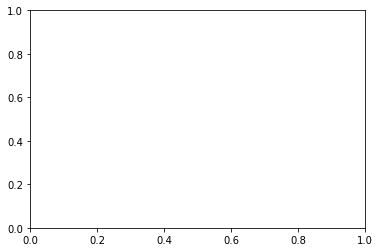

In [62]:

plt.plot(mse_list_indices,mse_list)
plt.xlabel("frame")
plt.ylabel("mse")

plt.show()

mse_list

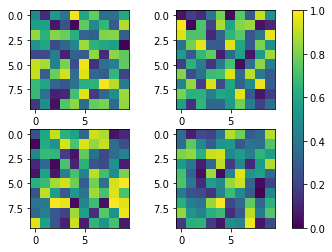

In [30]:

# Python Program illustrating
# pyplot.colorbar() method
import matplotlib.pyplot as plt
  
# creates four Axes
fig, axes = plt.subplots(nrows=2, ncols=2)
  
for ax in axes.flat:
    im = ax.imshow(np.random.random((10, 10)), vmin=0, vmax=1)
  
plt.colorbar(im, ax=axes.ravel().tolist())
  
plt.show()

In [55]:
mse_list = []
arr = np.empty((25,25), dtype="float32")
for i in range (0,25):
        s = mse(imstack2[i,115:350,115:350], imstack2[0, 115:350,115:350])
        mse_list.append(s)
        np.append(arr[0,:],mse_list)
for i in range (0,25):
        s = mse(imstack2[i,115:350,115:350], imstack2[1, 115:350,115:350])
        mse_list.append(s)
        np.append(arr[1,:],mse_list)
for i in range (0,25):
        s = mse(imstack2[i,115:350,115:350], imstack2[2, 115:350,115:350])
        mse_list.append(s)
        np.append(arr[2,:],mse_list)       
for i in range (0,25):
        s = mse(imstack2[i,115:350,115:350], imstack2[3, 115:350,115:350])
        mse_list.append(s)
        np.append(arr[3,:],mse_list)
for i in range (0,25):
        s = mse(imstack2[i,115:350,115:350], imstack2[4, 115:350,115:350])
        mse_list.append(s)
        np.append(arr[4,:],mse_list)
for i in range (0,25):
        s = mse(imstack2[i,115:350,115:350], imstack2[5, 115:350,115:350])
        mse_list.append(s)
        np.append(arr[5,:],mse_list) 
        
#M[row_number, :]

In [72]:
mse_list = []
arr = np.zeros((25,25), dtype="float32")


for j in range (0,25):
    for i in range (0,25):
            arr[j,i] = mse(imstack2[i,115:350,115:350], imstack2[j, 115:350,115:350])
            #mse_list.append(s)
    #np.append(arr[j,:],mse_list)
    


6.0185423268447265

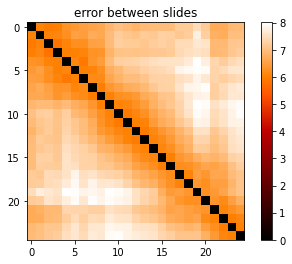

In [82]:

plt.imshow(arr,cmap='gist_heat')
plt.title("error between slides")
plt.colorbar()

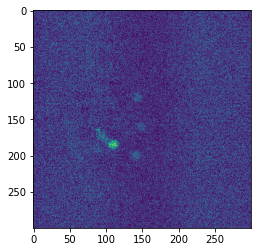

In [39]:
cropp_test = imstack2[1,:,:]

cropp_test1 = cropp_test[100:400,100:400]
plt.imshow(cropp_test1)

In [10]:
from scipy import signal

In [ ]:
from pathlib import Path
import cv2, os
base_path = "D:/20220623_PollenBrain1/ZSeries-06232022-1119-043"
new_path = "D:/20220623_PollenBrain1"
for infile in os.listdir(base_path):
    print ("ZSeries-06232022-1119-043_Cycle00001_Ch2_000047.ome : " + infile)
    read = cv2.imread(base_path + infile)
    outfile = infile.split('.')[0] + '.jpg'
    cv2.imwrite(new_path+outfile,read,[int(cv2.IMWRITE_JPEG_QUALITY), 200])

In [ ]:
im1

In [ ]:
im1 = plt.imread('D:/20220623_PollenBrain1/ZSeries-06232022-1119-043/ZSeries-06232022-1119-043_Cycle00001_Ch2_000040.ome.tif')
im2 = plt.imread('D:/20220623_PollenBrain1/ZSeries-06232022-1119-043/ZSeries-06232022-1119-043_Cycle00001_Ch2_000041.ome.tif')

In [ ]:

cor = signal.correlate2d (im1, im2)

In [1]:
!pip install jupyterthemes 

     ---------------------------------------- 7.0/7.0 MB 22.4 MB/s eta 0:00:00
     ---------------------------------------- 46.7/46.7 kB ? eta 0:00:00
     ---------------------------------------- 49.6/49.6 kB 2.5 MB/s eta 0:00:00


In [2]:
!jt -l 

Available Themes: 
   chesterish
   grade3
   gruvboxd
   gruvboxl
   monokai
   oceans16
   onedork
   solarizedd
   solarizedl


In [5]:
!jt -t gruvboxd -T -N -kl 